# Trim Traces based on Spiked Power
**WARNING: This Notebook alters the Traces in the configured directory**

This script allows trimming of a set of traces that have the interesting part wedged between 2 amplitude spikes that are greater than other normal amplitude changes in the trace. 

The firmware for the CC1310 was configured to use such spikes for this research. 

As this notebook alters files on the disk, you should make sure you understand the assumptions accept the risk. Always back up your data before running a disk altering script. 

In [3]:
import os, random, gc
import scipy.io
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm #progress bar for visualization of progress


# Helper function to return directory contents sorted by datetime (oldest first)
def sorted_ls(path, sortby="mtime", require_ext=False):
    if sortby=="fsize":
        sortkey = lambda f: os.path.getsize(os.path.join(path, f))
    else:
        sortkey = lambda f: os.stat(os.path.join(path, f)).st_mtime
    file_list = list(sorted(os.listdir(path), key=sortkey))
    if require_ext != False:
        file_list = [x for x in file_list if x.endswith(require_ext)]
    return file_list

# Helper function to standardize graphs and reduce code size
def ShowTrace(title, xlabel, ylabel, ydata, fig_size=(10, 6), xdata=None, ylim=None):
    plt.figure(figsize=fig_size, dpi=80)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if ylim!= None:
        ax = plt.gca()
        ax.set_ylim([0, ylim]) 
    if xdata!= None:
        plt.plot(xdata, ydata)
    else:
        plt.plot(ydata)
    plt.show()

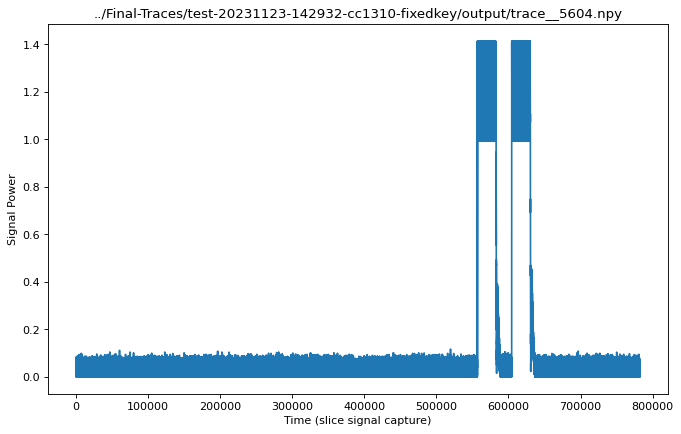

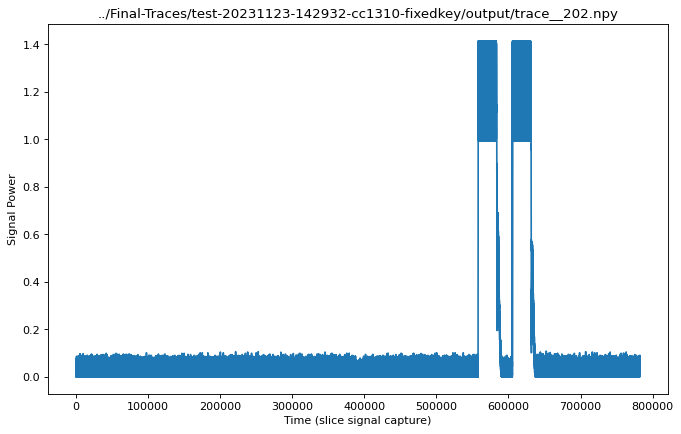

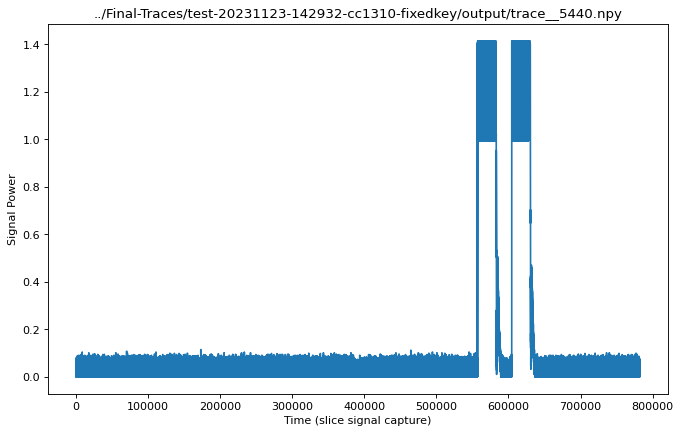

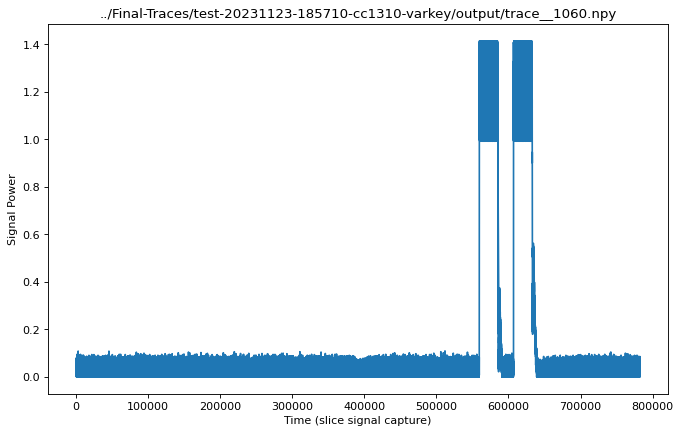

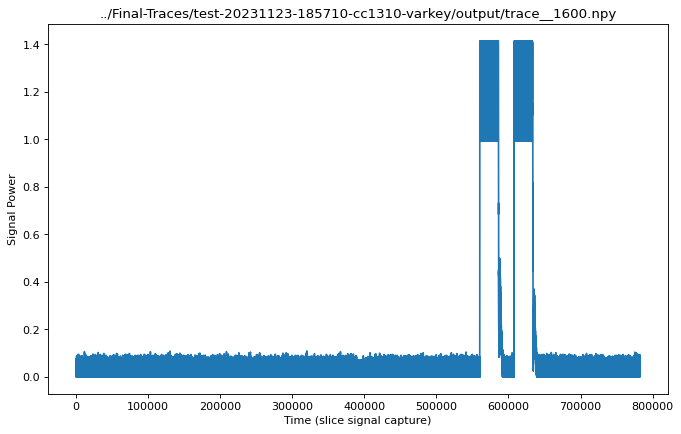

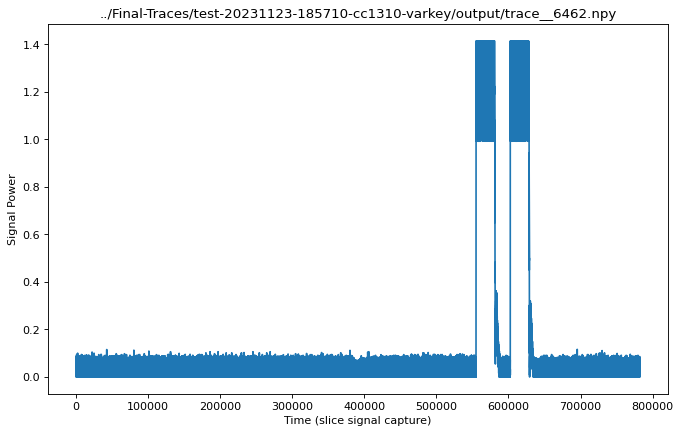

In [5]:

I_UNDERSTAND_THAT_THIS_SCRIPT_WILL_ALTER_FILES_ON_DISK = False #Change to True to proceed

paths = ["../Final-Traces/test-20231123-142932-cc1310-fixedkey/output/", 
        "../Final-Traces/test-20231123-185710-cc1310-varkey/output/"]

for path in paths:
    for i in range(3):
        filename = random.choice(sorted_ls(path, require_ext=".npy"))
        glance = np.absolute(np.load(path+filename))
        ShowTrace(path+filename, "Time (slice signal capture)", "Signal Power", glance)

In [10]:


if(not I_UNDERSTAND_THAT_THIS_SCRIPT_WILL_ALTER_FILES_ON_DISK):
    raise("Must change this variable to true to acknowledge that data on disk will be changed")


trigger_power = 0.6 #the amplitude that indicates the signal is in a spike (based on above graph)
allowed_gap_in_spike=1000 #as the signal amplitude could drop slightly during a spike, we should allow for such a short drop

for path in paths:
    dir_list = sorted_ls(path, sortby="mtime", require_ext=".npy")
    for filename in tqdm(dir_list, desc="Extracting for "+path):
        end_of_first_spike = -1
        start_of_second_spike = -1
        trace = np.absolute(np.load(path+filename))
        for k,data in enumerate(trace):
            if(data > trigger_power):
                if end_of_first_spike == -1 or k<=(end_of_first_spike+allowed_gap_in_spike):
                    end_of_first_spike = k
                else:
                    start_of_second_spike = k
                    break
        if end_of_first_spike == -1 or start_of_second_spike == -1:
            raise Exception("Couldn't detect 2 spikes for "+path+filename)
        np.save(path+filename, trace[end_of_first_spike:start_of_second_spike])
        
        del trace #help garbage collection

Extracting for ../Final-Traces/test-20231123-142932-cc1310-fixedkey/output/: 100
Extracting for ../Final-Traces/test-20231123-185710-cc1310-varkey/output/: 100%|
